# Unsupervised Learning: relationship between the variables

In this example, we will use KAN for unsupervised learning. 

Instead of trying to figure out how a target variable $y$ depends on input variables, we treat all variables on the equal footing (as input variables). 

Below we contruct a synthetic dataset where we have six variables $x_1, x_2, x_3, x_4, x_5, x_6$. 
    - $(x_1, x_2, x_3)$ are dependent such that $x_3 = cos(x_1)+ x_2$;
    - $(x_4,x_5)$ are dependent such that $x_4=sin(x_5)$. 
    - $x_6$ is independent of all other variables. 

Can we use KANs to discover these dependent groups?

The idea is that we treat the problem as a classification problem. 

The dataset that satisfies these interdependent relations are 'positive' samples, while corrupted samples (by random permutation of features across samples) are 'negative' samples. 

We want to train a KAN to output 1 when it is a positive sample, and output 0 when it is a negative sample. 

We set the last layer activation to be Gaussian, so positive samples will have zero activation in the second to last layer, while negtive samples will have non-zero activation in the second to last layer. 





**Step 1**: create the dataset and instance the realtionship between the variables 

In [1]:
from kan import KAN
import torch
import copy

def create_dataset(train_num=500, test_num=500):
    
    def generate_contrastive(x):
        # positive samples
        batch = x.shape[0]
        x[:,0] = torch.cos(x[:,1])+ x[:,2]
        x[:,3] = torch.sin(x[:,4])

        # negative samples
        def corrupt(tensor):
            y = copy.deepcopy(tensor)
            for i in range(y.shape[1]):
                y[:,i] = y[:,i][torch.randperm(y.shape[0])]
            return y

        x_cor = corrupt(x)
        x = torch.cat([x, x_cor], dim=0)
        y = torch.cat([torch.ones(batch,), torch.zeros(batch,)], dim=0)[:,None]
        return x, y
        
    x = torch.rand(train_num, 6) * 2 - 1
    x_train, y_train = generate_contrastive(x)
    
    x = torch.rand(test_num, 6) * 2 - 1
    x_test, y_test = generate_contrastive(x)
    
    dataset = {}
    dataset['train_input'] = x_train
    dataset['test_input'] = x_test
    dataset['train_label'] = y_train
    dataset['test_label'] = y_test
    return dataset

dataset = create_dataset()

The results reported in the paper rely on randomness, according to the seed set. 
We decided to investigate a more systematic way to find the best value for the seed parameter. So we implemented a method to train with different seed the KAN and obtain the wanted realtionship between the variabiles. 

In [2]:
seed = 1
model = KAN(width=[6,1,1], grid=3, k=3, seed=seed)

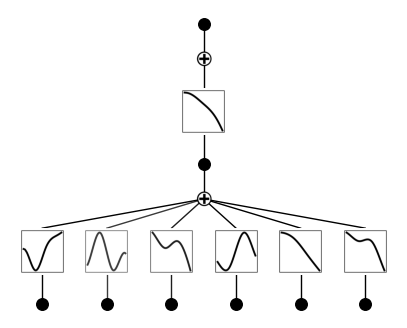

In [3]:
model(dataset['train_input'])
model.plot(beta=10)

In [4]:
# set the (1,0,0) activation to be gausssian
#model.fix_symbolic(1,0,0,lambda x: torch.exp(-x**2/10),fit_params_bool=False)
model.fix_symbolic(1,0,0,'gaussian',fit_params_bool=False)

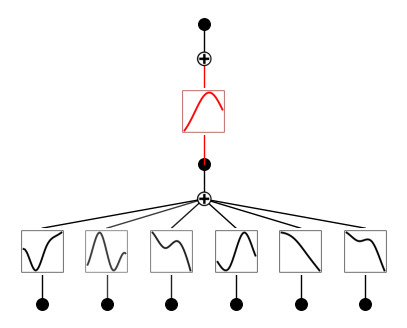

In [5]:
model(dataset['train_input'])
model.plot(beta=10)

In [6]:
scores = []
for seed in range (10):
    model = KAN(width=[6, 1, 1], grid=3, k=3, seed=seed)
    model(dataset['train_input'])
    model.fix_symbolic(1,0,0,'gaussian',fit_params_bool=False)
    model.fit(dataset, opt="LBFGS", steps=100, lamb=0.01, lamb_coef=1.0);
    sorted = torch.sort(model.feature_score)
    score = torch.mean(sorted.values[-2:]).item()
    positions = (torch.sort(sorted.indices[-2:]).values).numpy()
    scores.append((score, positions))
    print(seed, scores[-1])

train loss: 1.78e-01 | test loss: 2.16e-01 | reg: 7.70e+00 : 100%|█| 100/100 [00:10<00:00,  9.88it/s


0 (0.9908812046051025, array([0, 2]))


train loss: 1.33e-01 | test loss: 1.78e-01 | reg: 7.58e+00 : 100%|█| 100/100 [00:07<00:00, 12.57it/s


1 (1.0180381536483765, array([3, 4]))


train loss: 1.62e-01 | test loss: 2.05e-01 | reg: 7.64e+00 :  14%|▏| 14/100 [00:01<00:11,  7.50it/s]


KeyboardInterrupt: 

In [ ]:
scores

In [ ]:
# computation of the best seed value 
best_seed = torch.argmax(torch.Tensor([s[0] for s in scores])).item()
print("The best seed to set is: ", best_seed)


Train again the model with the best seed

In [ ]:
model = KAN(width=[6, 1, 1], grid=3, k=3, seed=best_seed)
model(dataset['train_input'])
model.fix_symbolic(1,0,0,'gaussian',fit_params_bool=False)
model.fit(dataset, opt="LBFGS", steps=100, lamb=0.01, lamb_coef=1.0);
model.plot(beta=10)

In [ ]:
for i in torch.argsort(torch.Tensor([s[0] for s in scores])).tolist()[::-1]:
    print(scores[i])

In [ ]:
model = KAN(width=[6, 1, 1], grid=3, k=3, seed=0)
model(dataset['train_input'])
model.fix_symbolic(1,0,0,'gaussian',fit_params_bool=False)
model.fit(dataset, opt="LBFGS", steps=100, lamb=0.01, lamb_coef=1.0);
model.plot(beta=10)

In [ ]:
model = KAN(width=[6, 1, 1], grid=3, k=3, seed=6)
model(dataset['train_input'])
model.fix_symbolic(1,0,0,'gaussian',fit_params_bool=False)
model.fit(dataset, opt="LBFGS", steps=100, lamb=0.01, lamb_coef=1.0);
model.plot(beta=10)